In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (16, 7)

# Overview of the data structure: 
Our main dataset [Dunnhumby - The complete journey](https://www.dunnhumby.com/careers/engineering/sourcefiles) comprises 8 csv files with the following tabular structure and content.

#### Campaign Desc
Description | Campaign ID | Start and End Day
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int (probably day count from study)

#### Campaign Table
Description | Campaign ID | Household key
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int

#### Casual Data
Product ID | Store ID | Week | Display location | Mailer location
--- | --- | --- | --- | --- 
int | int | int | int | String
 | | | Advertisement in in-store display? | Featured as ad in weekly mailer
 
#### Coupon Redemption
Household ID | Day | Coupon ID | Campaign ID 
--- | --- | --- | --- 
int | int | int | int 

#### Coupon
Coupon ID | Product ID | Campaign ID 
--- | --- | ---  
int | int | int 

#### Demographic
Age | Marital Status Code | Income | Homeowner | Household composition | Household size | Number of kids | Household Id
--- | --- | --- | --- | --- | --- | --- | --- |
(19-65+) | {A: Married, B: Single, U: Unknown} | | {Homeowner, Retired, etc.} | {Female/Male single, adults with/without kids, etc.} || (1-3+) |


#### Products
Product Id | Manufacturer Id | Departement  | Brand | Commodity description | Sub commodity description | Size
--- | --- | --- | --- | --- | --- | --- 
 | | {grocery, pastry, etc.} | {national/private} | | |
 
### Transaction
Household Id | Manufacturer Id | Week | Day | Time of Day | Product Id | Quantity | Sales value | Store Id | Retail discount | Coupon discount | Coupon match discount
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
 | | | | | | | What the shop actually gets | | | Loyalty program of retailer | Shop does not get price before discount | Shop does get price before discount


# Loading the data

Let's start by loading the data in pandas dataframes.

## Causal data

In [ ]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')

In [ ]:
df_causal.head()

Let's define two dict for the code meaning of display and mailer.

In [ ]:
display_dict = {0:'Not on Display', 1:'Store Front', 2:'Store Rear', 3:'Front End Cap',
                4:'Mid-Aisle End Cap', 5:'Read End Cap' ,6:'Side-Aisle End Cap', 7:'In-Aisle' ,
                9:'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {0:'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

## Coupon redemption

In [ ]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')

In [ ]:
df_coupon_redempt.head()

Let's study how many coupons were redeemed for each campaign.

In [ ]:
df_coupon_redempt.groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC', logy = True) 
plt.xlabel('Campaign')
plt.ylabel('Number of coupons redeemed')
plt.title('Number of coupons redeemded per campaign')
plt.show()

## Coupon

In [ ]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')

In [ ]:
df_coupon.head()

Let's study how many coupons were distributed for each campaign.

In [ ]:
df_coupon.groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC', logy = True) 
plt.xlabel('Campaign')
plt.ylabel('Number of coupons distributed')
plt.title('Number of coupons distributed per campaign')
plt.show()

We notice there are definetely some campaigns with way more coupons than others. Is this related to the type of campaign?

Let's add a column stating if a coupon has been redeemed or not.

In [ ]:
df_coupon['REDEEMED'] = df_coupon['COUPON_UPC'].isin(df_coupon_redempt['COUPON_UPC'])
df_coupon.head()

We can now observe the number of coupons that were not redeemed for each campaign.

In [ ]:
df_coupon[~df_coupon['REDEEMED']].groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC', logy = True) 
plt.xlabel('Campaign')
plt.ylabel('Number of coupons not redeemed')
plt.title('Number of coupons not redeemed per campaign')
plt.show()

## Demographics

In [ ]:
df_demo = pd.read_csv('dunnhumby/hh_demographic.csv')

In [ ]:
print(df_demo.head(20))
df_demo["AGE_DESC"].unique()

In [ ]:
df_demo.head()

## Products

In [ ]:
df_products = pd.read_csv('dunnhumby/product.csv')

Let's explore the product data frame and filter out anything food related. We start by looking at the column *DEPARTMENT*.

In [ ]:
list_dep = np.sort(df_products["DEPARTMENT"].unique())
list_commodity = np.sort(df_products["COMMODITY_DESC"].unique())
list_sub = np.sort(df_products["SUB_COMMODITY_DESC"].unique())

frames = {}
for l in list_dep:    
    frames[l] = df_products[df_products["DEPARTMENT"].apply(lambda x : x == l)]

In [ ]:
print(df_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False))

Let's observe the biggest categories and see whats in it.

In [ ]:
frames["GROCERY"]["COMMODITY_DESC"].unique()

As expected the category **Grocery** is all over the place and contains basically anything what can be bought in a grocery store. The category is not really helpful and we have to check the sub categories.

Lets check **Drug Gm** next and see, if there is anythin food-related in it.

In [ ]:
frames["DRUG GM"]["COMMODITY_DESC"].unique()

* 'DIETARY AID PRODUCTS' (candy bar, novelty candy, candy bags-chocolate)
* 'CANDY - PACKAGED'
* 'CANDY - CHECKLANE'
* 'INFANT FORMULA'
* 'BABY FOODS' 
* 'DOMESTIC GOODS'
* 'NATURAL HBC' (novelty candy)

After looking at the commodities individually , these do have some food related stuff in them.

In the end the following *DEPARTMENT* values are food related. There still some a lot of non food items. We have to filter them out.

In [ ]:
list_dep_food = ["GROCERY", "DRUG GM", "PRODUCE", "NUTRITION", "MEAT","MEAT-PCKGD","DELI","PASTRY", "SEAFOOD-PCKGD", "SEAFOOD", 
                 "RESTAURANT", "MISC SALES TRAN", "SALAD BAR", "TRAVEL & LEISUR", "FROZEN GROCERY", "CHEF SHOPPE", "DAIRY DELI", 
                 "GM MERCH EXP", "DELI/SNACK BAR", "GRO BAKERY", "PORK", "MEAT-WHSE"]
non_food = ["COSMETICS", "FLORAL", "CHARITABLE CONT", "MISC. TRANS.", "SPIRITS", "GARDEN CENTER", 
            "COUP/STR & MFG", "KIOSK-GAS", "RX", "CNTRL/STORE SUP", "POSTAL CENTER", "TOYS", 
            "VIDEO RENTAL", "PHOTO", "PROD-WHS SALES", "CHARITABLE CONT", "AUTOMOTIVE", "VIDEO", 
            "ELECT &PLUMBING","HOUSEWARES", "PHARMACY SUPPLY", "HBC", " "]
print(list_dep_food)

In [ ]:
df_food_dep = df_products[df_products["DEPARTMENT"].apply(lambda x : x in list_dep_food)]
df_meat_dep = df_food_dep[df_food_dep["COMMODITY_DESC"].str.contains("MEAT")]
df_fish_dep = df_food_dep[df_food_dep["COMMODITY_DESC"].str.contains("FISH")]
np.sort(df_food_dep["COMMODITY_DESC"].unique())

In [ ]:
list_food_com = ['APPLES', 'BABY FOODS', 'BABYFOOD',
       'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING',
       'BAKING MIXES', 'BAKING NEEDS',
       'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES',
       'BEVERAGE',
       'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS',
       'BROCCOLI/CAULIFLOWER', 'BULK FOODS', 'BUTTER',
       'CAKES', 'CANDY - CHECKLANE',
       'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS', 'CEREAL/BREAKFAST',
         'CHEESE', 'CHEESES', 'CHICKEN',
       'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL',
        'CITRUS', 'COCOA MIXES', 'COFFEE', 'COFFEE SHOP', 'COFFEE SHOP SWEET GOODS&RETAIL',
       'COLD CEREAL', 'CONDIMENTS', 'CONDIMENTS/SAUCES', 'CONVENIENT BRKFST/WHLSM SNACKS', 'COOKIES',
       'COOKIES/CONES', 'CORN', 'CRACKERS/MISC BKD FD', 'DELI MEATS',
       'DELI SPECIALTIES (RETAIL PK)', 'DELI SUPPLIES', 'DINNER MXS:DRY',
       'DINNER SAUSAGE', 'DOMESTIC GOODS',
       'DOMESTIC WINE', 'DRIED FRUIT', 'DRY BN/VEG/POTATO/RICE',
       'DRY MIX DESSERTS', 'DRY NOODLES/PASTA', 'DRY SAUCES/GRAVY',
       'DRY TEA/COFFEE/COCO MIX', 'EASTER', 'EGGS','EXOTIC GAME/FOWL',
       'FALL AND WINTER SEASONAL',
       'FITNESS&DIET', 'FLOUR & MEALS', 'FLUID MILK PRODUCTS', 'FROZEN',
       'FROZEN - BOXED(GROCERY)', 'FROZEN BREAD/DOUGH', 'FROZEN CHICKEN',
       'FROZEN MEAT', 'FROZEN PACKAGE MEAT', 'FROZEN PIE/DESSERTS',
       'FROZEN PIZZA', 'FRUIT - SHELF STABLE', 'FRZN BREAKFAST FOODS',
       'FRZN FRUITS', 'FRZN ICE', 'FRZN JCE CONC/DRNKS',
       'FRZN MEAT/MEAT DINNERS', 'FRZN NOVELTIES/WTR ICE',
       'FRZN POTATOES', 'FRZN SEAFOOD', 'FRZN VEGETABLE/VEG DSH', 'GRAPES',  'HEAT/SERVE', 'HERBS', 'HISPANIC',
       'HOME FREEZING & CANNING SUPPLY','HOT CEREAL', 'HOT DOGS',
        'ICE CREAM/MILK/SHERBTS',
       'IMPORTED WINE',
       'INFANT FORMULA',
       'ISOTONIC DRINKS',  'JUICE' , 'LAMB',
        'LIQUOR', 'LUNCHMEAT',
        'MARGARINES', 'MEAT - MISC', 'MEAT - SHELF STABLE',
       'MEAT SUPPLIES', 'MELONS', 'MILK BY-PRODUCTS', 'MISC WINE',
       'MISC. DAIRY', 'MISCELLANEOUS', 'MISCELLANEOUS CROUTONS',
       'MOLASSES/SYRUP/PANCAKE MIXS', 'MUSHROOMS', 'NATURAL HBC',
       'NATURAL VITAMINS', 'NDAIRY/TEAS/JUICE/SOD', 'NEW AGE',
        'NON-DAIRY BEVERAGES', 'NUTS',
       'OLIVES', 'ONIONS',
       'ORGANICS FRUIT & VEGETABLES', 
       'PACKAGED NATURAL SNACKS', 
       'PARTY TRAYS', 'PASTA SAUCE', 'PEARS', 'PEPPERS-ALL',
       'PICKLE/RELISH/PKLD VEG', 'PIES', 'PKG.SEAFOOD MISC',
        'PNT BTR/JELLY/JAMS', 'POPCORN', 'PORK',
        'POTATOES',
       'PREPARED FOOD',
       'PREPARED/PKGD FOODS', 'PROCESSED', 'PROD SUPPLIES',
       'PWDR/CRYSTL DRNK MX', 'QUICK SERVICE', 'REFRGRATD DOUGH PRODUCTS',
       'REFRGRATD JUICES/DRNKS', 'REFRIGERATED', 'RESTRICTED DIET',
       'RICE CAKES', 'ROLLS', 'RW FRESH PROCESSED MEAT', 'SALAD BAR',
       'SALAD MIX', 'SALADS/DIPS', 'SALD DRSNG/SNDWCH SPRD', 'SANDWICHES',
       'SEAFOOD - FROZEN', 'SEAFOOD - MISC', 'SEAFOOD - SHELF STABLE',
       'SEAFOOD-FRESH', 'SEASONAL', 'SERVICE BEVERAGE',  'SHORTENING/OIL',
        'SMOKED MEATS', 
       'SNACK NUTS', 'SNACKS', 'SNKS/CKYS/CRKR/CNDY', 'SOFT DRINKS', 'SOUP', 'SPICES & EXTRACTS',
       'SPORTS MEMORABLILIA', 'SPRING/SUMMER SEASONAL', 'SQUASH',
        'STONE FRUIT', 'SUGARS/SWEETNERS',
        'SUSHI', 'SWEET GOODS & SNACKS', 'SYRUPS/TOPPINGS',
       'TEAS', 'TOMATOES', 
       'TROPICAL FRUIT', 'TURKEY', 'UNKNOWN', 
       'VALUE ADDED FRUIT', 'VALUE ADDED VEGETABLES', 'VEAL',
       'VEGETABLES - ALL OTHERS', 'VEGETABLES - SHELF STABLE',
       'VEGETABLES SALAD', 'WAREHOUSE SNACKS', 'WATER',
       'WATER - CARBONATED/FLVRD DRINK', 'YOGURT']
print(list_food_com)

In [ ]:
df_food_com = df_food_dep[df_food_dep["COMMODITY_DESC"].apply(lambda x : x in list_food_com)]

In the column *COMMODITY_DESC*, there are some categories, which are non ambigously only contain food items. But there are still categories like *BAKING NEEDS* which can contain non food items. We need to check their *SUB_COMMODITY_DESC* values for a description on the lowest level.

In [ ]:
list_food_com_ambigious=['CHRISTMAS  SEASONAL', 'DOMESTIC GOODS','EASTER', 'FALL AND WINTER SEASONAL','HOME FREEZING & CANNING SUPPLY', 'NATURAL HBC', 'NATURAL VITAMINS','SEASONAL', 'SPORTS MEMORABLILIA', 'SPRING/SUMMER SEASONAL']

BAKING MIXES, BAKING NEEDS contains seafood?!?

Commodities to throw out (except):
* NATURAL HBC – CANDY
* NATURAL VITAMINS – PRETZELS
* SEASONAL – PUMPKINS
* SPORTS MEMORABLILIA – CANDY
* 'SPRING/SUMMER SEASONAL' – CANDY

In [ ]:
df_amb_com = df_food_com[df_food_com["COMMODITY_DESC"].apply(lambda x : x in list_food_com_ambigious)]
throw_out =['MISC', 'BAKING CUPS', 'CAKE DECORS - BIRTHDAY CANDLES', 'BANDANA/SCARVES', 'FLASHLIGHTS','AS SEEN ON TV', 'MISC BULK', 'MISC SALES TRANS','PEYTON/GM EXPENSE ITEMS', 'MICROWAVE'] 

for amb in list_food_com_ambigious:
    for item in df_amb_com[df_amb_com["COMMODITY_DESC"].apply(lambda x : x == amb)]["SUB_COMMODITY_DESC"].unique():
        if not "CANDY" in item and not "PUMPKINS" in item and not "PRETZELS" in item:
            throw_out.append(item)


Final dataframe with only food.

In [ ]:
df_food = df_food_com[df_food_com["SUB_COMMODITY_DESC"].apply(lambda x : not x in throw_out)]

df_food

In [ ]:
def filter_dataframe(df, word_list):
    filtered_df = df.copy()
    for word in word_list:
        filtered_df = filtered_df[~(filtered_df["DEPARTMENT"].str.contains(word) | filtered_df["COMMODITY_DESC"].str.contains(word) | filtered_df["SUB_COMMODITY_DESC"].str.contains(word))]
    return df[~df.index.isin(filtered_df.index)]

In [ ]:
meat_list = ["MEAT","PORK", "BEEF", "DUCK", "CHICKEN", "POULTRY", "LAMB", "VEAL", "MUTTON", "TURKEY", "VENISON", "WILD BOAR", "BISON", "GOOSE", "RABBIT", "PHEASANT"]
seafood_list = ["HERRING", "SEAFOOD", "SEAFD","SUSHI", "FISH","SHRIMP","SALMON","TUNA","TILAPIA","ALASKA","POLLOCK","PANGASIUS","BASA","SWAI","COD","CATFISH","CRAB","CLAMS"]
sweets_snack_list = ["ROLLS", "PASTRY", "NUT","CRACKERS","DESSERT","SNKS","SNACK","CHIP", "CANDY", "ICE", "SWEET", "CHOCOLATE","POPCORN", "CAKE", "COOKIE", "PANCAKE", "BAKING", "BAKE", "PIE"]
fruits_list = ["FRUIT","APPLE", "ORANGE", "PEAR", "BANANA", "GRAPE", "BERR", "TOMATO", "LEMON", "MELON", "PEACH", "CHERR", "PINEAPPLE", "CITRUS"]
vegetable_list = ["PUMPKIN", "COLESLAW", "SPINACH", "BEAN","VEG", "POTATO", "CARROT","CORN","PEPPER", "SQUASH", "ONION", "MUSHROOM", "CUCUMBER", "CAULIFLOWER", "BROCCOLI", "OLIVE" ]
veg_animal_list = ["DAIRY","MILK","CHEESE", "YOGURT", "BUTTER", "MARGARINE", "EGG", "HONEY"]
beverage_list = ["CIDER", "BEVERAGE", "WATER", "COKE", "FANTA", "SPRITE","LIQUOR", "LEMONADE", "COCOA", "BEER", "WINE", "COFFEE", "DRINK", "TEA", "JUICE", "DRNKS", "JCE"]
condiment_list = ["SALSA","FLOUR", "DIP","OIL","SEASONING","JELLY", "JAM","SAUCE", "HERBS", "CONDIMENT", "TOPPING", "SYRUP", "DRESSING", "KETCHUP", "MAYO", "DRSNG"]
carbs_list = ["NOODLES", "PASTA", "CROUTON","RICE", "BREAD", "TOAST", "CEREAL", "OATMEAL", "DOUGH", "POTATO"]
meal_list = ["PIZZA", "RAMEN", "SANDWICH", "SALAD","SOUP","ENTREE", "DINNER", "BREAKFAST", "THAI", "ASIAN", "ITALIAN", "MEXICAN", "GERMAN", "BURRITO", "FOOD", "ORIENTAL", "DISH"]
df_meat = filter_dataframe(df_food, meat_list)
df_seafood = filter_dataframe(df_food, seafood_list)
df_sweets_snack = filter_dataframe(df_food, sweets_snack_list)
df_fruits = filter_dataframe(df_food, fruits_list)
df_vegetable = filter_dataframe(df_food, vegetable_list)
df_veg_animal = filter_dataframe(df_food, veg_animal_list)
df_beverage = filter_dataframe(df_food, beverage_list)
df_condiments = filter_dataframe(df_food, condiment_list)
df_carbs = filter_dataframe(df_food, carbs_list)
df_meals = filter_dataframe(df_food, meal_list)
df_left = df_food[~df_food.index.isin(np.concatenate((df_meat.index,df_seafood.index, df_sweets_snack.index, df_fruits.index, df_vegetable.index, df_beverage.index, df_veg_animal.index, df_condiments.index, df_carbs.index, df_meals.index)))]

In [ ]:
df_left["SUB_COMMODITY_DESC"].unique()

## Transaction data

In [ ]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')

In [ ]:
df_transaction.head()

Let's precise what does the less obvious column represent. The SALES_VALUE is the amount of dollar received by the retailer for a particular sale. The RETAIL_DISC is a discount applied due to retailer's loyalty card program. The COUPON_DISC is a discount applied due to manufacturer coupon and COUPON_MATCH_DISC a discount applied due to retailer's match of manufacturer coupon. Finally, the TRANS_TIME correspond to the time of the day the purchase was made (ranging from 0 to 2359, i.e. from 0:00 to 23:59)

In [ ]:
print('The TRANS_TIME ranges between %d and %d.' %(df_transaction['TRANS_TIME'].min(), df_transaction['TRANS_TIME'].max()))

Let's add the actual product prices (with or without loyalty card). To do so, we use the following formulas (as explained in the user guide):  
    - Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity  
    - Non-loyalty card price = (sales_value – (coupon_match_disc))/quantity 
    

In [ ]:
df_transaction['LOYALTY_CARD_PRICE'] = (df_transaction['SALES_VALUE'] - (df_transaction['RETAIL_DISC'] + df_transaction['COUPON_MATCH_DISC']))/df_transaction['QUANTITY']
df_transaction['NO_LOYALTY_CARD_PRICE'] = (df_transaction['SALES_VALUE'] - df_transaction['COUPON_MATCH_DISC'])/df_transaction['QUANTITY']
df_transaction.head()

# Campaign analysis 

Let's start by loading the data.

In [ ]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')

In [ ]:
df_campaign_desc.head()

In [ ]:
df_campaign_table.head()

Let's see how many campaigns we have.

In [ ]:
print('Number of campaign: ', len(df_campaign_desc.CAMPAIGN))
print('Unique description: ', df_campaign_desc.DESCRIPTION.sort_values().unique())

We add the duration of each campaign.

In [ ]:
df_campaign_desc['DURATION'] = df_campaign_desc['END_DAY'] - df_campaign_desc['START_DAY'] 
df_campaign_desc.sort_values(by = ['DESCRIPTION', 'DURATION']).head()

For each type of campaign, we compute some basic statistics.

In [ ]:
for camp in ['TypeA', 'TypeB', 'TypeC']:
    print('Campaigns of %s range between %d and %d days' %(camp, df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.min(),
                                                     df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.max()))
    print('with a mean duration of %.2f days and a median duration of %.2f days.' 
            %(df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.mean(),
              df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.median()))

Let's see the different campaigns over time.

In [ ]:
#Split the datas per campaign type for better visualization
beginA = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA']['START_DAY'].values
endA =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA']['END_DAY'].values
beginB = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB']['START_DAY'].values
endB =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB']['END_DAY'].values
beginC = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC']['START_DAY'].values
endC =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC']['END_DAY'].values

#Plot the timespan of each campaign (note the +1 to match the indexes starting at 0 with the campaign numbers starting at 1)
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA'].index.values + 1,  endA-beginA, left=beginA, 
         color = 'red', label = 'TypeA')
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB'].index.values + 1,  endB-beginB, left=beginB, 
         color = 'blue', label = 'TypeB')
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC'].index.values + 1,  endC-beginC, left=beginC, 
         color = 'green', label = 'TypeC')

#Add title & legend
plt.title('Timespan of each campaign')
plt.ylabel('Campaign')
plt.yticks(df_campaign_desc.index + 1)
plt.xlabel('Time')
plt.legend()
plt.show()

Let's observe the distribution of the number of campaigns the household have benefited from.

In [ ]:
nbins = df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max()
df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().hist(bins = nbins)
plt.title('Distribution of the number of campaigns per household')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.show()

We also print some basic statistics on the number of campaigns each household has benefited from.

In [ ]:
print('Mean number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().mean())
print('Median number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().median())
print('Max number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max())
print('25% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.25),
      'campaigns or less.')
print('75% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.75),
      'campaigns or less.')
print('95% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.95),
      'campaigns or less.')

We can now move to more advanced analysis. Let's start by combining this data with the coupon data.

In [ ]:
df_campaign_desc.sort_values(by = 'CAMPAIGN', inplace = True)
df_campaign_desc.set_index(keys = 'CAMPAIGN', drop = True, inplace = True)
df_campaign_desc['DISTRIBUTED'] = df_coupon.groupby(by = 'CAMPAIGN').REDEEMED.count() #Number of coupons distributed
df_campaign_desc['REDEEMED'] = df_coupon[~df_coupon['REDEEMED']].groupby(by = 'CAMPAIGN').REDEEMED.count() #Number of coupons redeemed
df_campaign_desc.fillna(0, inplace = True) 
df_campaign_desc['BENEFICIARY'] = df_campaign_table.groupby(by = 'CAMPAIGN').DESCRIPTION.count() #Number of beneficiary households
df_campaign_desc.head()

Let's observe these results in a bar plot. For each campaign we plot the amount of coupon distributed and redeemed, and we add the type of the campaign.

In [ ]:
# set width of bar
barWidth = 0.4
 
# set height of bar
coupon_distributed = df_campaign_desc['DISTRIBUTED']
coupon_redeemed = df_campaign_desc['REDEEMED']
 
# Set position of bar on X axis
r = np.arange(len(coupon_distributed)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, coupon_distributed, width=barWidth, edgecolor='white', label='Distributed coupon')
plt.bar(r2, coupon_redeemed, width=barWidth, edgecolor='white', label='Redeemed coupon')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.DESCRIPTION.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], coupon_distributed.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amount of coupon per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of coupon')
plt.legend()
plt.show()

We can see the difference between the amount of coupon distributed and redeemed differs a lot from one campaign to another. It goes from cases where it is nearly null (such as campaign 1) to extreme cases where no coupons were redeemed (such as in campaigns 6, 15 and 24). To understand what happened here, we will need to inspect more precisely each campaign and join our results with data about the products and the transactions.

To do some further analysis, we will create a function *products_categories()* taking the number of a campaign and plotting the repartition of products for which coupons were offered based on the categories previously defined. It will also return this repartition as a dictionary with the proportion of each category as values and the categories as keys. A parameter *show_plot* will enable to show or not the plot (if only the proportions are needed).

In [99]:
categories = ['Meat', 'Seafood', 'Sweet snacks', 'Fruits', 'Vegetables', 'Veg animal', 'Beverage', 'Condiments', 'Carbs', 'Meals', 'Other']
df_list = (df_meat, df_seafood, df_sweets_snack, df_fruits, df_vegetable, 
           df_veg_animal, df_beverage, df_condiments, df_carbs, df_meals, df_left)

def products_categories(num_camp, distr = True, show_plot = False):
    proportions = dict.fromkeys(categories)
    
    #Compute the number of coupons in each category
    for categ,df in enumerate(df_list):
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons
        # and if looking for distributed or redeemed coupons
        if (num_camp in df.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().index and distr):
            proportions[categories[categ]] = df.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp][1] 
        elif num_camp in df.merge(df_coupon[df_coupon.REDEEMED], on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().index:  
                proportions[categories[categ]] = df.merge(df_coupon[df_coupon.REDEEMED],
                                                          on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp][1] 
        else:
            proportions[categories[categ]] = 0
        
    '''    
    proportions['Meat'] = df_meat.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Seafood'] = df_seafood.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Sweet snacks'] = df_sweets_snack.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Fruits'] = df_fruits.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Vegetables'] = df_vegetable.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Veg animal'] = df_veg_animal.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Beverage'] = df_beverage.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Condiments'] = df_condiments.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Carbs'] = df_carbs.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Meals'] = df_meals.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    proportions['Other'] = df_left.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp,1]
    '''
    
    #Compute the proportion as percentage
    total = 0
    for i in proportions.values(): 
           total += i 
    if total != 0:
        for key in proportions.keys():
            proportions[key] = 100*proportions[key]/total
    
    #Plot the repartitions of products for which coupons were offered
    if show_plot:
        plt.bar(range(len(proportions)), list(proportions.values()), align='center')
        plt.xticks(range(len(proportions)), list(proportions.keys()))
        plt.title('Proportions of coupons distributed per category during campaign ' + str(num_camp))
        plt.xlabel('Categories')
        plt.ylabel('Proportion of coupons [%]')
    
    return proportions

Let's see how the coupons distributed are spread over the different categories for campaign 4 for instance.

{'Meat': 0.0,
 'Seafood': 0.0,
 'Sweet snacks': 57.57575757575758,
 'Fruits': 0.0,
 'Vegetables': 2.6515151515151514,
 'Veg animal': 13.257575757575758,
 'Beverage': 0.3787878787878788,
 'Condiments': 11.742424242424242,
 'Carbs': 11.742424242424242,
 'Meals': 2.6515151515151514,
 'Other': 0.0}

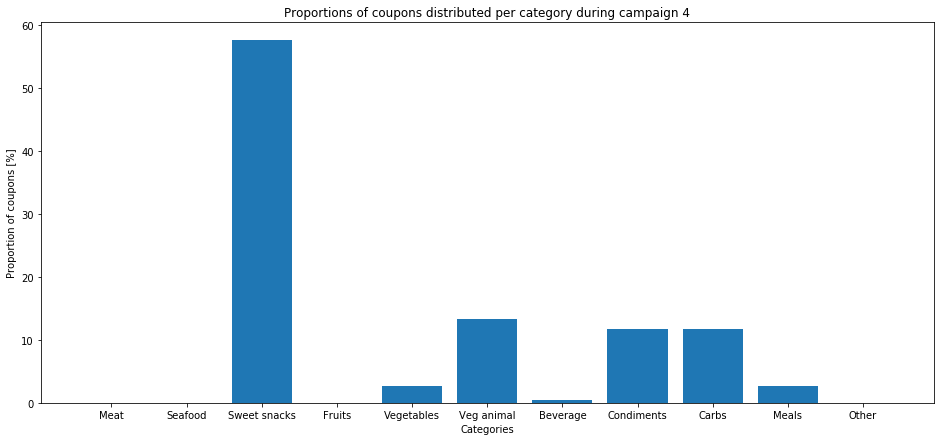

In [102]:
products_categories(4, True, True)

We can see this campaign was mainly about sweet snacks.

Let's now take a more overall view, across all campaign. We will compute the proportions of coupons in each category for all campaigns and plot the results in a stacked bar plot.

In [ ]:
proportions_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_overall = proportions_overall.append(products_categories(i+1), ignore_index = True)
proportions_overall.set_index(df_campaign_desc.index, inplace = True)

In [ ]:
proportions_overall.head()

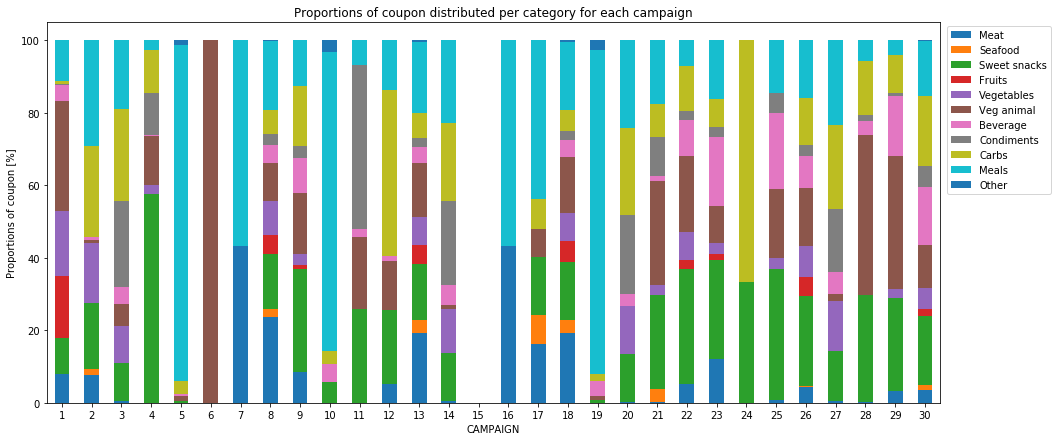

In [86]:
proportions_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

## Join Food and Transaction

In [ ]:
df_food_trans = pd.merge(df_food, df_transaction, on='PRODUCT_ID', how='left')

In [ ]:
number_households = len(df_food_trans["household_key"].unique())
number_households

Let's check what percentile of the households did not buy meat and seafood products at all.

In [ ]:
df_meat_seafood = df_meat.append(df_seafood)
df_meat_seafood.drop_duplicates()

In [ ]:
df_meat_seafood_trans = pd.merge(df_meat_seafood, df_transaction, on='PRODUCT_ID', how='left')
number_household_meat_seafood = len(df_meat_seafood_trans["household_key"].unique())
print("Number of households who did not purchased any meat or seafood: % d" %(number_households-number_household_meat_seafood))

In [ ]:
weekly_meat_sea = df_meat_seafood_trans.groupby("WEEK_NO").count()["PRODUCT_ID"]
weekly_trans = df_food_trans.groupby("WEEK_NO").count()["PRODUCT_ID"]
plt.plot(weekly_meat_sea)
plt.xlabel("Week")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transactions [Weekly]")
plt.show()

Overall there is no upwards or downwards trend of meat and seafood transactions. But it is weird that the meat and seafood transactions rose rapidly in the first few weeks. It is likely that in the beginning not all transactions were caught. We take a look at the relation between the number of transactions and the number of meat and seafood transactions. If the rise in the beginning is only due to the fact that not all transactions were recorded, then the relation should be linear.

In [ ]:
plt.scatter(weekly_trans, weekly_meat_sea)
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transaction in Relation to overall Number of Transactions [Weekly]")
plt.show()

The relation is indeed linear.

Next we take a look at the number of households which weekly buy meat or seafood products.

In [ ]:
plt.plot(df_meat_seafood_trans.groupby("WEEK_NO")["household_key"].nunique())
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Households that purchased Meat and Seafood Transactions [Weekly]")
plt.show()

The number again stays relatively stable at around 800-900. That is surprising, because the number of households which did purchase a meat product in the two years is 2475.

Let's check the number of households, which go vegetarian in a week.

In [ ]:
weekly_vege = df_food_trans.groupby("WEEK_NO")["household_key"].nunique()-df_meat_seafood_trans.groupby("WEEK_NO")["household_key"].nunique()
plt.plot(weekly_vege)
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Relation of overall households and households that bought meat or seafood [Weekly]")
plt.show()

Surprisingly the number is super high considering that almost all households do not live completely vegetarian. Lets check the frequency of the meat and seafood purchases of all households.

In [ ]:
house_purchase = df_meat_seafood_trans.groupby("household_key").count()["PRODUCT_ID"]
print(house_purchase)
plt.hist(weekly_house_purchase, bins=50)
plt.xlabel("Number of meat and seafood transactions")
plt.ylabel("Frequency")
plt.title("Histrogram for Meat and SEAFOOD transaction in a household")
plt.show()

In [ ]:
house_purchase.sort_values().head(50)

Lets check the 